<a href="https://colab.research.google.com/github/shreyaaaaaa21/variational-autoencoders/blob/main/IMAGE_DENOISING_USING_VARIATIONAL_ENCODER.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

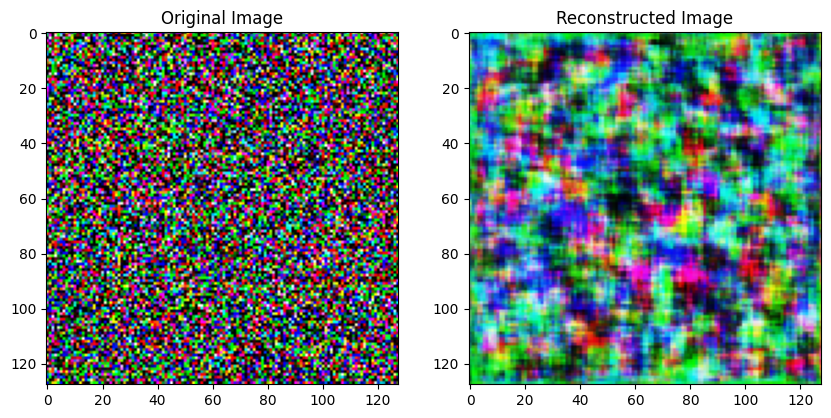

In [13]:


import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

# Assuming you have your image data loaded as 'image'

# Define the model (based on your provided code)
class Autoencoder(nn.Module):
    def __init__(self, features_d=64):
        super(Autoencoder, self).__init__()
        self.features_d = features_d

        # Encoder
        self.enc_block1 = self._enc_block(3, features_d, kernel_size=3, stride=2, padding=1)
        self.enc_block2 = self._enc_block(features_d, features_d * 2, kernel_size=3, stride=2, padding=1)
        self.enc_block3 = self._enc_block(features_d * 2, features_d * 4, kernel_size=3, stride=2, padding=1)

        # Latent space
        self.conv_mu = nn.Sequential(
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(features_d * 4),
            nn.ReLU(),
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),
        )
        self.conv_logvar = nn.Sequential(
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),
            nn.BatchNorm2d(features_d * 4),
            nn.ReLU(),
            nn.Conv2d(
                features_d * 4, features_d * 4, kernel_size=3, stride=1, padding=1
            ),
        )

        # Decoder
        self.dec_block1 = self._dec_block(features_d * 4, features_d * 2, kernel_size=3, stride=1, padding=1)
        self.dec_block2 = self._dec_block(features_d * 2, features_d, kernel_size=3, stride=1, padding=1)
        self.dec_block3 = nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ConvTranspose2d(
                features_d, 3, kernel_size=3, stride=1, padding=1, bias=False
            ),
            nn.Sigmoid()  # Output should be in [0, 1]
        )

    def _enc_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Conv2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def _dec_block(self, in_channels, out_channels, kernel_size, stride, padding):
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode="nearest"),
            nn.ConvTranspose2d(
                in_channels,
                out_channels,
                kernel_size=kernel_size,
                stride=stride,
                padding=padding,
                bias=False,
            ),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(),
        )

    def encode(self, x):
        x = self.enc_block1(x)
        x = self.enc_block2(x)
        x = self.enc_block3(x)
        mu = self.conv_mu(x)
        logvar = self.conv_logvar(x)
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return eps * std + mu

    def decode(self, z):
        z = self.dec_block1(z)
        z = self.dec_block2(z)
        z = self.dec_block3(z)
        return z

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        recon_x = self.decode(z)
        return recon_x, mu, logvar

    def loss_function(self, recon_x, x, mu, logvar):
        recon_loss = F.mse_loss(recon_x, x)
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + kld_loss


# Create an instance of the model
model = Autoencoder()

# Assuming 'image' is your input image
# Preprocess the image if necessary (e.g., normalize to [0, 1])
image = torch.randn(1, 3, 128, 128)  # Example image

# Pass the image through the model
recon_x, mu, logvar = model(image)

# Convert the output to a numpy array for visualization
recon_x = recon_x.detach().numpy().squeeze()
recon_x = recon_x.transpose(1, 2, 0)  # Reshape for visualization

# Display the original and reconstructed images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(image.detach().numpy().squeeze().transpose(1, 2, 0))
plt.title("Original Image")
plt.subplot(1, 2, 2)
plt.imshow(recon_x)
plt.title("Reconstructed Image")
plt.show()
